In [ ]:
!pip install statsmodels

## **<font color='#8d5383'>import library</font>**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gammaln
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedPoisson

sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

In [ ]:
def simulate_zicmp_data(n_samples=2000, seed=42):
    np.random.seed(seed)
    X = np.random.uniform(-1.5, 1.5, size=(n_samples, 3))

    true_lambda = np.exp(1.0 + 0.8 * X[:, 0] - 0.5 * X[:, 1])
    true_pi = 1 / (1 + np.exp(-(0.5 - 1.5 * X[:, 1] + 0.2 * X[:,0]**2)))
    true_nu = np.exp(0.1 + 0.6 * X[:, 2])

    y = np.zeros(n_samples)

    y_range = np.arange(0, 100)
    log_fact_y = gammaln(y_range + 1)

    for i in range(n_samples):
        if np.random.uniform(0, 1) < true_pi[i]:
            y[i] = 0
        else:
            lam_i, nu_i = true_lambda[i], true_nu[i]

            # Calculate log Z
            log_z_terms = y_range * np.log(lam_i) - nu_i * log_fact_y
            log_z = np.logaddexp.reduce(log_z_terms)

            # Calculate PMF
            log_pmf_values = y_range * np.log(lam_i) - nu_i * log_fact_y - log_z
            pmf_values = np.exp(log_pmf_values)
            pmf_values /= np.sum(pmf_values)

            y[i] = np.random.choice(y_range, p=pmf_values)

    return X, y

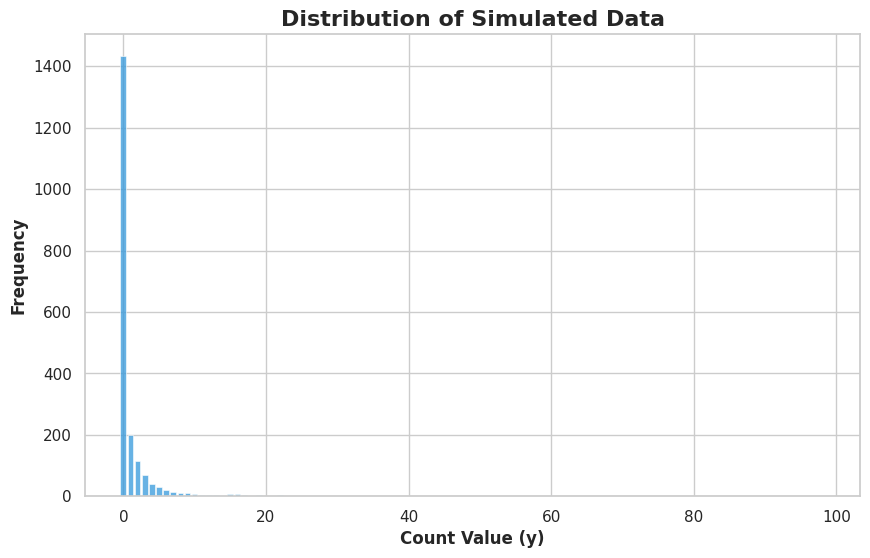

درصد مشاهدات صفر در داده‌ها: 71.65%


In [ ]:
# Generate data and split
X, y = simulate_zicmp_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Visualize the generated data
plt.figure(figsize=(10, 6))
sns.histplot(y, discrete=True, color='#3498db', shrink=0.8)
plt.title('Distribution of Simulated Data', fontsize=16)
plt.xlabel('Count Value (y)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

print(f"درصد مشاهدات صفر در داده‌ها: {np.mean(y == 0) * 100:.2f}%")

## **<font color='#8d5383'>creare Models</font>**

In [ ]:
# Convert data to PyTorch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# 1. Define the Neural Network Architecture
class ZICMP_NN(nn.Module):
    def __init__(self, input_dim):
        super(ZICMP_NN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.lambda_head = nn.Linear(32, 1)
        self.pi_head = nn.Linear(32, 1)
        self.nu_head = nn.Linear(32, 1)

    def forward(self, x):
        shared_output = self.network(x)
        # استفاده از Softplus به جای exp برای پایداری بیشتر
        lam = nn.functional.softplus(self.lambda_head(shared_output))
        pi = torch.sigmoid(self.pi_head(shared_output))
        nu = nn.functional.softplus(self.nu_head(shared_output))
        return torch.cat([lam, pi, nu], dim=1)

# 2. Define the Custom Loss Function
def zicmp_nll_loss(y_pred_params, y_true, max_k=100):
    lam, pi, nu = y_pred_params[:, 0], y_pred_params[:, 1], y_pred_params[:, 2]
    y_true = y_true.squeeze()

    # Calculate log Z(lambda, nu)
    k = torch.arange(0, max_k, dtype=torch.float32, device=y_true.device).unsqueeze(0)
    log_z = torch.logsumexp(k * torch.log(lam.unsqueeze(1)) - nu.unsqueeze(1) * torch.lgamma(k + 1.0), dim=1)

    # Log-likelihood for y=0
    log_lik_zero = torch.log(pi + (1 - pi) * torch.exp(-log_z) + 1e-8)

    # Log-likelihood for y>0
    log_lik_positive = (torch.log(1 - pi + 1e-8) +
                        y_true * torch.log(lam + 1e-8) -
                        nu * torch.lgamma(y_true + 1.0) -
                        log_z)

    is_zero = (y_true == 0).float()
    log_likelihood = is_zero * log_lik_zero + (1 - is_zero) * log_lik_positive

    return -torch.mean(log_likelihood)

In [ ]:
# 3. Training Loop
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ZICMP_NN(input_dim=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = zicmp_nll_loss

epochs = 120
train_losses = []
train_mses = [] # To store MSE for each epoch
train_rmses = [] # To store RMSE for each epoch
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_mse = 0
    total_rmse = 0
    num_batches = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred_params = model(X_batch)
        loss = loss_fn(y_pred_params, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        # Calculate MSE and RMSE for the batch
        y_pred_mean = (1 - y_pred_params[:, 1]) * (y_pred_params[:, 0] ** (1 / y_pred_params[:, 2]))
        batch_mse = torch.mean((y_pred_mean - y_batch.squeeze())**2)
        batch_rmse = torch.sqrt(batch_mse).item()
        total_mse += batch_mse.item()
        total_rmse += batch_rmse
        num_batches += 1

    avg_loss = total_loss / num_batches
    avg_mse = total_mse / num_batches
    avg_rmse = total_rmse / num_batches
    train_losses.append(avg_loss)
    train_mses.append(avg_mse)
    train_rmses.append(avg_rmse)


    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, MSE: {avg_mse:.4f}, RMSE: {avg_rmse:.4f}')

Epoch [10/120], Loss: 1.1101, MSE: 18.9852, RMSE: 3.8552
Epoch [20/120], Loss: 0.9842, MSE: 67.7651, RMSE: 6.9997
Epoch [30/120], Loss: 0.9737, MSE: 27.5007, RMSE: 4.9113
Epoch [40/120], Loss: 0.9687, MSE: 23.2119, RMSE: 4.4528
Epoch [50/120], Loss: 0.9661, MSE: 21.0352, RMSE: 4.1686
Epoch [60/120], Loss: 0.9659, MSE: 19.1323, RMSE: 4.0182
Epoch [70/120], Loss: 0.9669, MSE: 18.4658, RMSE: 3.9781
Epoch [80/120], Loss: 0.9617, MSE: 18.5873, RMSE: 4.0373
Epoch [90/120], Loss: 0.9569, MSE: 18.2075, RMSE: 3.8618
Epoch [100/120], Loss: 0.9536, MSE: 17.9658, RMSE: 3.7967
Epoch [110/120], Loss: 0.9578, MSE: 18.1653, RMSE: 3.9310
Epoch [120/120], Loss: 0.9577, MSE: 19.9357, RMSE: 3.8957


## **<font color='#8d5383'>Models evaluation</font>**

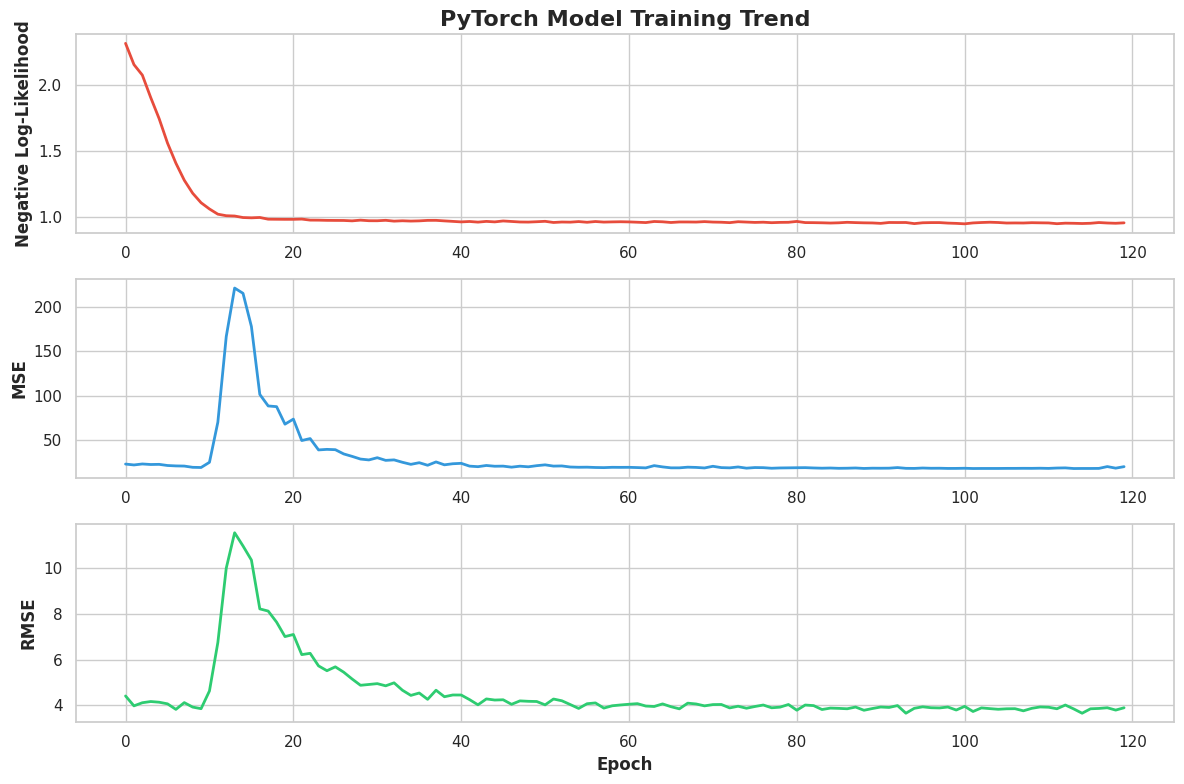

In [ ]:
# Plot training loss, MSE, and RMSE
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(train_losses, color='#e74c3c', linewidth=2)
plt.title('PyTorch Model Training Trend', fontsize=16)
plt.ylabel('Negative Log-Likelihood', fontsize=12)
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(train_mses, color='#3498db', linewidth=2)
plt.ylabel('MSE', fontsize=12)
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(train_rmses, color='#2ecc71', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit models
poisson_model = sm.Poisson(y_train, X_train_sm).fit(disp=0)
neg_bin_model = sm.NegativeBinomial(y_train, X_train_sm).fit(disp=0)
zip_model = ZeroInflatedPoisson(y_train, X_train_sm).fit(disp=0)

In [ ]:
# Get predictions from PyTorch model
model.eval()
with torch.no_grad():
    y_pred_params = model(X_test_t.to(device)).cpu().numpy()
    pred_zicmp_mean = (1 - y_pred_params[:, 1]) * (y_pred_params[:, 0] ** (1 / y_pred_params[:, 2]))

# Get predictions from other models
pred_poisson = poisson_model.predict(X_test_sm)
pred_neg_bin = neg_bin_model.predict(X_test_sm)
pred_zip = zip_model.predict(X_test_sm)

# Calculate Log-Likelihood and AIC for PyTorch model
with torch.no_grad():
    nll_zicmp = loss_fn(torch.tensor(y_pred_params), y_test_t).item()
logL_zicmp = -nll_zicmp * len(y_test)
num_params_zicmp = sum(p.numel() for p in model.parameters())
aic_zicmp = 2 * num_params_zicmp - 2 * logL_zicmp


--- Final Model Comparison Table ---
                   Model  Log-Likelihood          AIC
0  Zero-Inflated Poisson    -1675.991185  3361.982369
1      Negative Binomial    -1727.013204  3464.026408
2        ZICMP (PyTorch)     -483.940661  5837.881322
3                Poisson    -3273.111371  6554.222741


/tmp/ipython-input-2988063996.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AIC', y='Model', data=results.sort_values(by='AIC', ascending=False), ax=axes[0], palette=colors)
/tmp/ipython-input-2988063996.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Log-Likelihood', y='Model', data=results.sort_values(by='Log-Likelihood'), ax=axes[1], palette=colors)


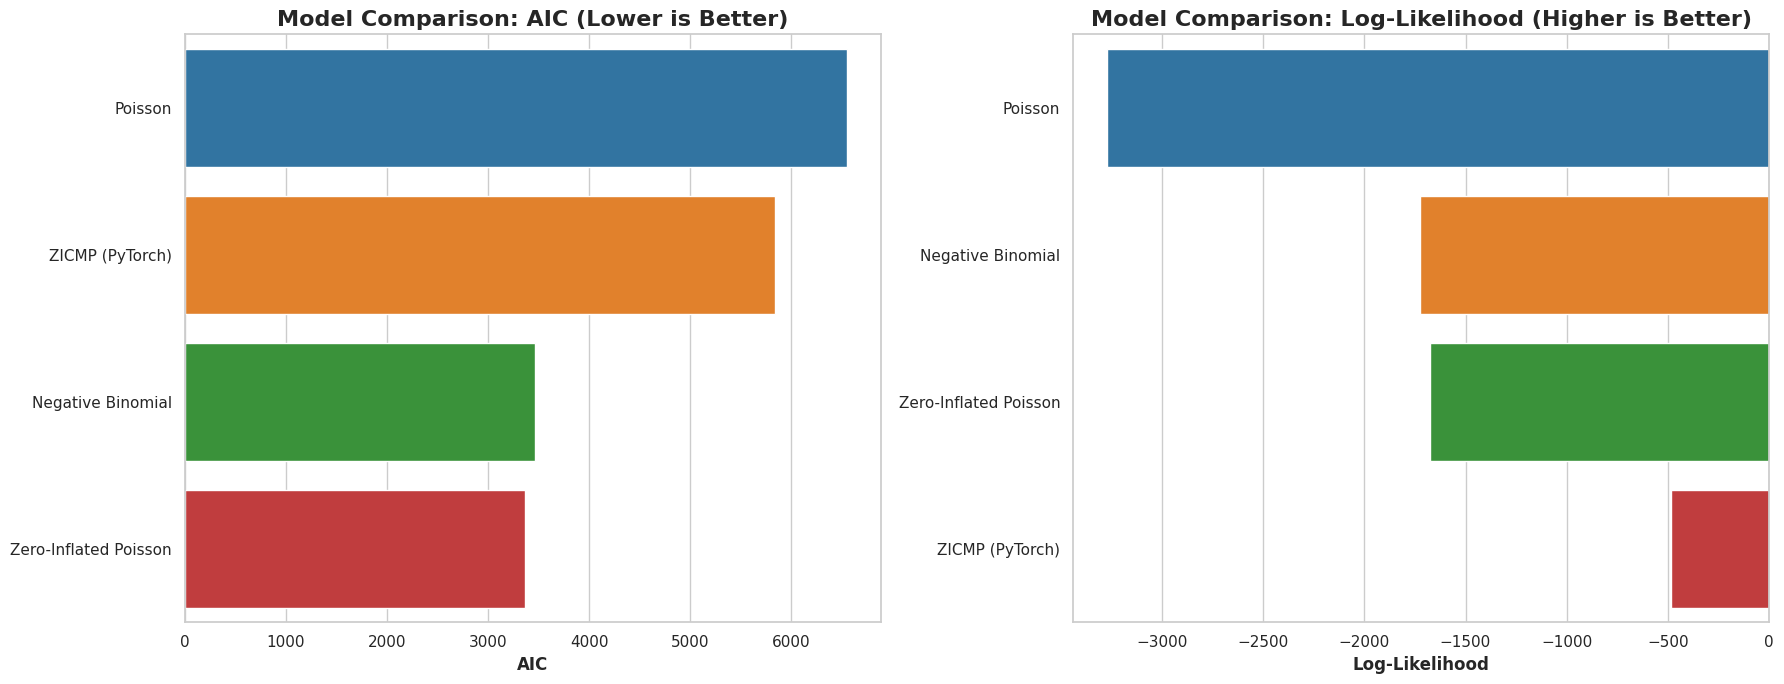

In [ ]:
# Create results DataFrame
results = pd.DataFrame({
    'Model': ['Poisson', 'Negative Binomial', 'Zero-Inflated Poisson', 'ZICMP (PyTorch)'],
    'Log-Likelihood': [poisson_model.llf, neg_bin_model.llf, zip_model.llf, logL_zicmp],
    'AIC': [poisson_model.aic, neg_bin_model.aic, zip_model.aic, aic_zicmp]
})

print("\n--- Final Model Comparison Table ---")
print(results.sort_values(by='AIC').reset_index(drop=True))

# --- Beautiful Comparison Charts ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# AIC Chart
sns.barplot(x='AIC', y='Model', data=results.sort_values(by='AIC', ascending=False), ax=axes[0], palette=colors)
axes[0].set_title('Model Comparison: AIC (Lower is Better)', fontsize=16)
axes[0].set_xlabel('AIC', fontsize=12)
axes[0].set_ylabel('')

# Log-Likelihood Chart
sns.barplot(x='Log-Likelihood', y='Model', data=results.sort_values(by='Log-Likelihood'), ax=axes[1], palette=colors)
axes[1].set_title('Model Comparison: Log-Likelihood (Higher is Better)', fontsize=16)
axes[1].set_xlabel('Log-Likelihood', fontsize=12)
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


--- Model Comparison Table (MSE) ---
                   Model        MSE
0        ZICMP (PyTorch)  24.151179
1  Zero-Inflated Poisson  25.652232
2                Poisson  25.869782
3      Negative Binomial  26.616353


/tmp/ipython-input-453532093.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MSE', y='Model', data=mse_results.sort_values(by='MSE', ascending=False), palette='viridis')


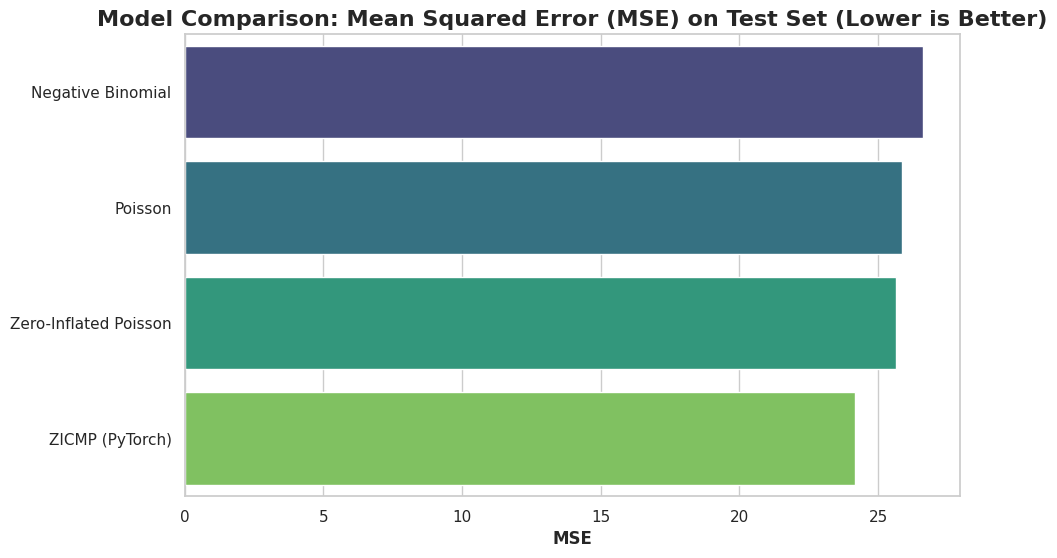

In [ ]:
# Calculate MSE for each model on the test set
mse_poisson = mean_squared_error(y_test, pred_poisson)
mse_neg_bin = mean_squared_error(y_test, pred_neg_bin)
mse_zip = mean_squared_error(y_test, pred_zip)
mse_zicmp = mean_squared_error(y_test, pred_zicmp_mean)

# Create a DataFrame for MSE comparison
mse_results = pd.DataFrame({
    'Model': ['Poisson', 'Negative Binomial', 'Zero-Inflated Poisson', 'ZICMP (PyTorch)'],
    'MSE': [mse_poisson, mse_neg_bin, mse_zip, mse_zicmp]
})

print("\n--- Model Comparison Table (MSE) ---")
print(mse_results.sort_values(by='MSE').reset_index(drop=True))

# Plot MSE comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='MSE', y='Model', data=mse_results.sort_values(by='MSE', ascending=False), palette='viridis')
plt.title('Model Comparison: Mean Squared Error (MSE) on Test Set (Lower is Better)', fontsize=16)
plt.xlabel('MSE', fontsize=12)
plt.ylabel('')
plt.show()

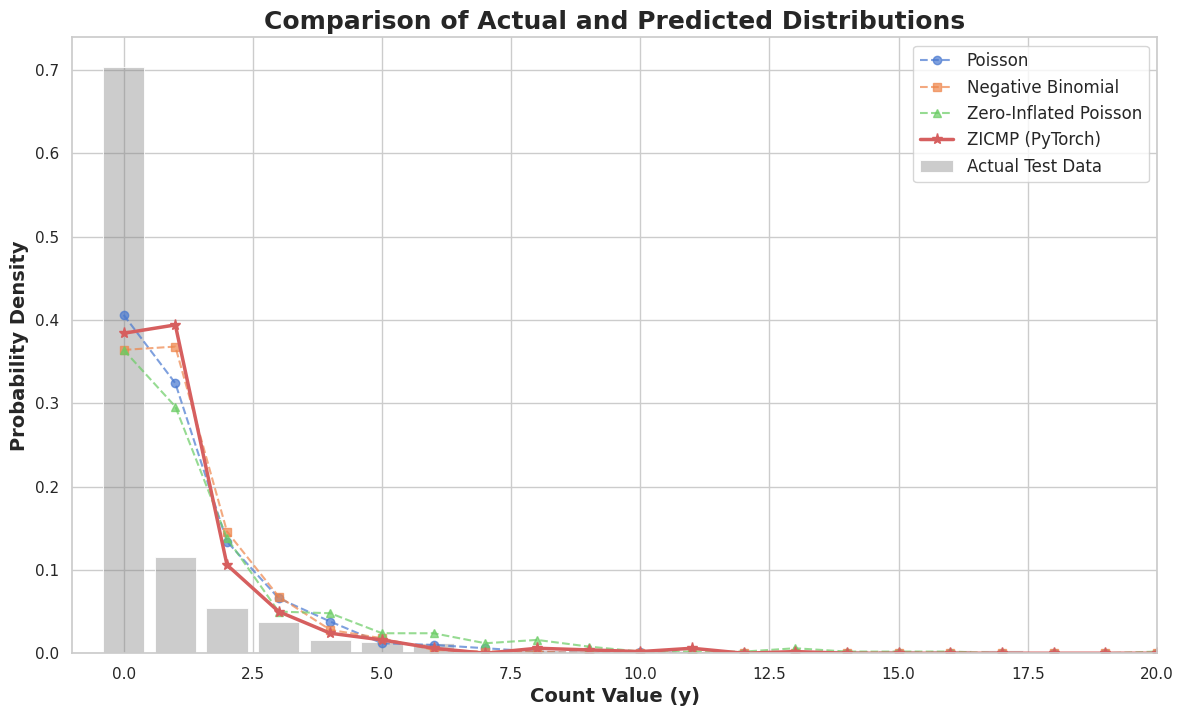

In [ ]:
plt.figure(figsize=(14, 8))
sns.histplot(y_test, stat='density', discrete=True, color='gray', alpha=0.4, label='Actual Test Data', shrink=0.8)

# Generate PMF for each model's average prediction
def get_predicted_dist(model_preds, x_range):
    # A simple way to visualize is to create a histogram of predictions
    counts, bins = np.histogram(np.round(np.clip(model_preds, 0, x_range.max())), bins=np.arange(x_range.max()+2)-0.5)
    return counts / counts.sum()

max_y = int(y_test.max())
x_range = np.arange(max_y + 1)

plt.plot(x_range, get_predicted_dist(pred_poisson, x_range), 'o--', label='Poisson', alpha=0.7)
plt.plot(x_range, get_predicted_dist(pred_neg_bin, x_range), 's--', label='Negative Binomial', alpha=0.7)
plt.plot(x_range, get_predicted_dist(pred_zip, x_range), '^--', label='Zero-Inflated Poisson', alpha=0.7)
plt.plot(x_range, get_predicted_dist(pred_zicmp_mean, x_range), '*-', markersize=8, linewidth=2.5, label='ZICMP (PyTorch)')


plt.title('Comparison of Actual and Predicted Distributions', fontsize=18)
plt.xlabel('Count Value (y)', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.xlim(-1, 20) # Zoom in on the most relevant part of the distribution
plt.legend(fontsize=12)
plt.show()